# Sample Complexity Gaps

Why can convolutional neural networks (CNNs) learn to classify images with less data than fully connected networks (FCNs)?

One way to empirically observe this difference is to measure how many training samples it takes for both models to reach a fixed accuracy at a fixed task on a range of input dimensions. If you can describe how the number of training samples grows as a function $\hat{g}$ of the input dimension $D$, then you have an empirical estimate of the sample complexity $\hat{g}(d)$.

**In this project**, We construct an image classification task based on the Fourier Transform, and empirically demonstrate a sample complexity gap on realistic CNN and FCN architectures. *Our claim is weak* - that for our chosen arrangement of models, learning rates, image range, labelling function, and learning algorithm, in an abundance of training data, our CNN learns with an estimated $O(1)$ samples, and our FCN learns with an estimated $\Omega(D^{2})$ samples. The value of this work is to better grasp what kind of natural tasks strongly distinguish the capabilities of CNNs and FCNs.

## Related work
We build off the work of [Li, Zhang, Arora (2020)](https://arxiv.org/pdf/2010.08515.pdf), who found a task that requires at least a factor of $D^2$ more training samples for FCNs than for CNNs, where $D$ is the data dimension. Their data distribution is $\mathcal{X}\subset \mathbb{R}^D \sim \mathcal{N}(0, 1)^D$. The target is given by the labelling function $h_2(x) = sgn(\sum_{i=1}^{D/2}x_i^2 - \sum_{i=D/2 +1}^{D}x_i^2)$. In an intuitive sense, this measures the brightness of two parts of an image. While we were able to replicate their heuristic experiment, we believe that it does not actually demonstrate the stated sample complexity gap of $\Omega(D^2)$. We aim to take care of this as well.

## Methods

We compare two models on two binary square image classification tasks.

### Tasks
Let $L\in\{10,12,14\dots,40\}$ be the image width, so $D:=l^2$ is the input dimension with $\mathcal{X}\subset \mathbb{R}^D$.
1. **Difference of brightness**
+ An input is an entry-wise normal square image $\mathcal{X} \ni X \sim \mathcal{N}(0, 1)^D$.

+ For $p>0$, define the labelling function $h_p(X)=\mathcal{1}[\sum_{i=1}^{D/2}x_i^p >\sum_{i=D/2 +1}^{D}x_i^p]$, where the pixels $x_i$ of $X$ are indexed in row-order.

+ Then $Y=h_p(X)$ is the corresponding label in $\{0, 1\}$.
2. **Noisy Fourier patterns**
+ Create a blank Fourier-domain square image $\dot{X}$ of side length $L$. 

+ Assign random complex units to up to $f=8$ random points in a low-pass box of side-length $L/2$ inside $\dot{X}$.

+ Then compute $|IFT(\dot{X})|$ with pixel-wise modulus and standardize the pixel values to mean $0$ and variance $1$. Call this $M$.

+ Generate a label $Y\sim \text{Ber}(p)$ in $\{0, 1\}$ with parameter $p=0.5$. If $Y=1$, obfuscate $M$ with noise $Z\sim \mathcal{N}(0, 1)^d$. 

+ Finally, $X = L^2\frac{M + YZ}{(||M + YZ||_1+10^{-6})}$
### Models
We compare a standard convolutional neural network with a max-pooling and linear layer to a two-layer neural network. Well-known learning theory results tells us that the number of parameters is a confounder on the sample complexity, so we match the number of parameters of the FCN to that of the CNN as best as possible by adjusting the number of hidden neurons $H$ in the FCN.
1. **Convolutional neural network** (CNN)
    + Convolutional layer : $1$ in channel, $1000$ out channels, kernel size $3$, stride $1$, padding $1$
    + Activation layer : $ReLU$
    + Max pool layer : kernel size $2$, stride $2$
    + Linear layer : ? in, $1$ out neuron
    + Sigmoid layer : $\sigma$
2. **Fully connected Network** (FCN)
    + Linear layer : $L^2$ in, $H$ out neurons
    + Activation layer : $ReLU$
    + Linear layer : $H$ in, $1$ out neuron
    + Sigmoid layer : $\sigma$

If the CNN has $|CNN|$ parameters, then let $H=\max\{1, \lceil |CNN| / (L^2+1)\rceil - 1\}$
### The training and testing protocol
+ We train with Adam and Binary Cross Entropy Loss, with freshly generated image batches of size $64$ since we assume an abundace of training data.
+ When the model obtains a training loss of 0.5, we test the model against a set of $1000$ fixed image-label pairs and compute accuracy $\alpha$.
+ If the obtained accuracy surpasses the requirement $\alpha > \epsilon = 0.75$, then stop. otherwise, lower the training loss goal by $0.025$ and continue training on new batches.
+ The learning rates we used are summarized in this table.

Learning rate table $0.0001$ for CNN, $0.005$ for FCNN.

# Empirical estimation

In [1]:
# Imports
import os
import sys
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from itertools import product
from helpers import *
from models import ModelLoader

<BarContainer object of 8 artists>

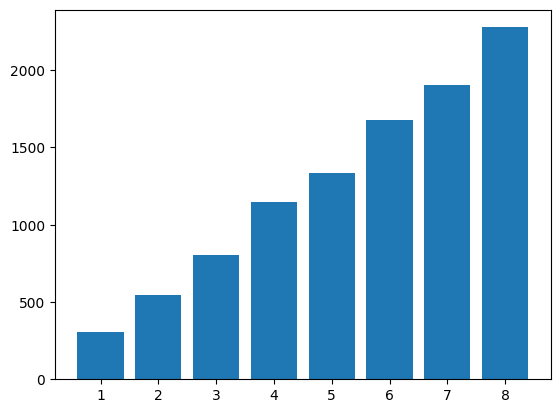

In [19]:
# Choose a number of frequencies
freqs = np.arange(1, 8+1)
freq = np.random.choice(a=freqs, p=freqs / np.sum(freqs), size=10000)
plt.bar(*np.unique(freq, return_counts=True))

We choose a particular setting for the estimation.

In [ ]:
# Fixed variables
min_w           = 10    # Minimum image width
max_w           = 40    # Maximum image width
N_te            = 1_000 # Test set
skip_w          = 2     # Skip widths
freq            = 8     # Max number of distinct frequencies            
batch_size      = 64    # Batch size
cnn_out_chans   = 1000  # The number of output channels in the CNN model
epsilon         = 0.75  # Required accuracy

# Experiment controls
delete          = False # Delete results of previous runs for that model.
relative        = True  # The box scales with the image size
balance         = False # Balance the results of the previous runs in case of stopping

# Setting
architecture    = "FCNN" 
activation      = "ReLU"
task_name       = "H1"
arch_name       = architecture + "+" + activation
learning_rate   = 0.005
estimates       = 5
filepath        = 'results/week14/acc'+str(int(epsilon * 100))+'freq'+str(freq)+'.pkl' # Results file